In [1]:
%matplotlib inline
import context
import os
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import keras as k
from keras.models import Sequential, Model
from keras.layers import Input, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, Concatenate, BatchNormalization, LocallyConnected1D
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.keras import regularizers
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = os.getcwd() + '/'
CHECKPOINTS_DIR = ROOT_DIR + 'checkpoints/'
construct = context.construct_neural_net
encode = context.encode_sequences
organize = context.organize_data

Using TensorFlow backend.


In [2]:
def encode_data(datapath):
    """
    This function reads in a file and outputs a file with each of the
    sequences encoded.
    Input: file path
    Output: file consisting of encoded sequences
    (encoded by scripted from encode_sequences file)
    """
    sequences, expression_levels, max_el = encode.encode_sequences_with_method(datapath, method='One-Hot', scale_els=True, model_type='1DLOCCON', binarized_els=True)
    return sequences, expression_levels, max_el

In [3]:
data = '/Users/Meenakshi Krishnan/Documents/DIRECT/Capstone/yeastpro/ExpressYeaself/example/processed_data/10000_from_20190612130111781831_percentiles_els_binarized_homogeneous_deflanked_sequences_with_exp_levels.txt.gz'
#organize.create_sample_data(data, 10000)

In [4]:
sequences, expression_levels, max_el = encode_data(data)

In [5]:
def data_shape(sequences):
    """
    This function reads in the np.array sequence matrix and outputs its
    dimensions. 
    Input: np.array
    Output: tuple consisting of the dimensions of the input matrix
    """
    shape = sequences.shape
    return shape

In [6]:
shape = data_shape(sequences)

In [7]:
def plot_results(fit):
    """
    This function takes the results from the model fit and evaluations
    and returns a visualization for the test-train accuracies and model
    losses.
    Input: model.fit() object results, specifically accuracies and 
    losses of the train and test data
    Output: matplotlib graphical visualizations of each
    """
    # Create plot with subplots
    fig, ax = plt.subplots(1, 2, figsize=(15,12))

    # Plot the accuracy plot
    ax1 = plt.subplot(221, xlabel='Epoch', ylabel='Accuracy', title='Model Accuracy Plot')
    ax1.plot(fit['acc'], color='goldenrod', lw=2, alpha=0.5)
    ax1.plot(fit['val_acc'], color='rebeccapurple', lw=2, alpha=0.5)

    # Plot the loss plot
    ax2 = plt.subplot(222, xlabel='Epoch', ylabel='Loss', title='Model Loss Plot')
    ax2.plot(fit['loss'], color='goldenrod', lw=2, alpha=0.5)
    ax2.plot(fit['val_loss'], color='rebeccapurple', lw=2, alpha=0.5)


    # create a list to store the axes
    axes_list = [ax1, ax2]
    # edit common components using a for loop
    for ax in axes_list:
        ax.title.set_fontsize(20) 
        ax.xaxis.label.set_fontsize(14) 
        ax.yaxis.label.set_fontsize(14)
        ax.legend(['Train', 'Test'], loc='upper left')

    return ax1, ax2

In [8]:
def tt_split(sequences, expression_levels):
    """
    This function reads in the np.array sequence matrix and expressions levels
    and performs a test-train split on the data.
    Input: np.array sequence matrix and expression levels
    Output: train_x, test_x, train_y, test_y
    """
    train_x, test_x, train_y, test_y = train_test_split(sequences, expression_levels, test_size=0.30)
    return train_x, test_x, train_y, test_y

In [38]:
# Define the model parameters
batch_size = len(expression_levels) * 0.01 # no bigger than 1 % of data
filters = 15
# kernel_size
strides = 1
epochs = 10
dropout = 0.1
num_layers = 5

# Define the inputs
x_input = shape[1]
y_input = shape[2]
inputs = Input(shape=(x_input, y_input))
layers = []

# Define the tensorboard and checkpointer if desired
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=(CHECKPOINTS_DIR + '1d_loccon_classifer_onehot.hdf5'), 
                               verbose=1, 
                               save_best_only=True)

# Build up the layers
for i in range(2, num_layers + 2):
    layer_lc = LocallyConnected1D(filters, kernel_size=(2 * i - 1), strides=strides, activation='relu')(inputs)
    layer_drop = Dropout(0.1)(layer_lc)
    layer_pool = MaxPooling1D(pool_size=15, data_format='channels_first')(layer_drop)
    layer_flat = Flatten()(layer_pool)
    layer_dense = Dense(40, activation='sigmoid')(layer_flat)
    layers.append(layer_dense)
    
# Combine the layers
combined = Concatenate(axis=1)(layers)

# Add some flatten, dense, and dropout layers
out = Dropout(dropout)(combined)
out = Dense(100, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(50, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(10, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation='sigmoid')(out)


# Define the model with inputs and outputs, and compile.
model = Model(inputs=inputs, outputs=out)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['mae', 'acc'])

# Print model summary
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 80, 5)        0                                            
__________________________________________________________________________________________________
locally_connected1d_86 (Locally (None, 78, 15)       18720       input_18[0][0]                   
__________________________________________________________________________________________________
locally_connected1d_87 (Locally (None, 76, 15)       29640       input_18[0][0]                   
__________________________________________________________________________________________________
locally_connected1d_88 (Locally (None, 74, 15)       39960       input_18[0][0]                   
__________________________________________________________________________________________________
locally_co

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 10s 1ms/step - loss: 0.6979 - mean_absolute_error: 0.4990 - acc: 0.5137 - val_loss: 0.6926 - val_mean_absolute_error: 0.4996 - val_acc: 0.5027

Epoch 00001: val_acc improved from -inf to 0.50267, saving model to C:\Users\Meenakshi Krishnan\Documents\DIRECT\Capstone\yeastpro\ExpressYeaself\expressyeaself\models\1d_loccon/checkpoints/1d_loccon_classifer_onehot.hdf5
Epoch 2/10
7000/7000 [==============================] - 3s 395us/step - loss: 0.6937 - mean_absolute_error: 0.4990 - acc: 0.5150 - val_loss: 0.6863 - val_mean_absolute_error: 0.4965 - val_acc: 0.6073

Epoch 00002: val_acc improved from 0.50267 to 0.60733, saving model to C:\Users\Meenakshi Krishnan\Documents\DIRECT\Capstone\yeastpro\ExpressYeaself\expressyeaself\models\1d_loccon/checkpoints/1d_loccon_classifer_onehot.hdf5
Epoch 3/10
7000/7000 [==============================] - 3s 395us/step - loss: 0.6548 - mean_absolute_err

'Values: loss: 0.4979221541881561 acc: 77.23333331743876%'

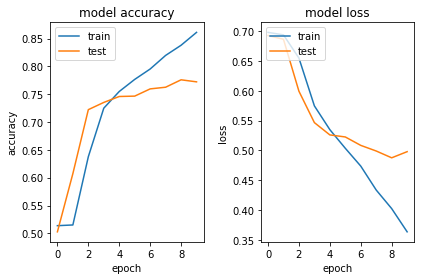

In [39]:
# initialize training and testing values
train_x, test_x, train_y, test_y = tt_split(sequences, expression_levels)

# fit model
fit = model.fit(train_x, train_y, epochs=10, batch_size=100, validation_data=(test_x, test_y), callbacks=[checkpointer])

# evaluate model (run tests)
scores = model.evaluate(test_x, test_y)

# plot results
#plt = plot_results(fit.history)
plt = construct.plot_results(fit.history)

# return model accuracy
("Values: "+ str(model.metrics_names[0]) + ': ' + str(scores[0]) + ' ' + str(model.metrics_names[2]) + ': ' + str(scores[2]*100) + '%')